In [47]:
#export
import math
import numpy as np
import xarray as xr
import logging

In [48]:
#export
logging.basicConfig(level=logging.INFO,
                    filename="logger.TEF.GETM",
                    filemode="w",
                    format="%(asctime)-15s %(levelname)-8s %(message)s")
logger = logging.getLogger(__name__)

In [188]:
#export
class TEF_object():

    def __init__(self, filename = None, ds = None, **kwargs):

        # What happens if no filename is provided
        if not filename:
            if ds is None:
                self.ds = None
            else:
                self.ds = ds
            return

        # continue with filename
        try:
            self.ds = None
            self.read(filename, **kwargs)
        except (OSError, IOError, RuntimeError):
            try:
                self.read(filename, **kwargs)
            except Exception:
                raise IOError("Unkown file format. Known formats are netcdf.")

        self.flux = None

    def __repr__(self):
        try:
            string = "xarray dataset with {} time steps \n" \
                     "Available fields: {}".format(
                self.timesteps, ", ".join(self.variables)
            )
        except AttributeError:
            string = "Empty TEF object \n" \
                     "Hint: Have you used read() to load data?"
        return string

    def __str__(self):
        return 'Class {}: \n'.format(self.__class__.__name__, self.ds)

    def __len__(self):
        return len(self.ds)

    def __getattr__(self, attr):
        if attr in self.__dict__:
            return getattr(self, attr)
        return getattr(self.ds, attr)

    def __getitem__(self, key):
        return self.ds[key]

    @property
    def timesteps(self):
        if len(self.ds.dims) != 3:
            logger.warning(
                "\nDimensions should be equal to 3, but they are not.\n"
                "You want ... "
            )
            return self.ds.dims[self._get_name_time()]
        return self.ds.dims[self.get_name_time()]

    @property
    def variables(self):
        return list(self.ds.data_vars)

    @property
    def dimensions(self):
        return list(self.ds.dims)

    def read(self, filename, **kwargs):
        if self.ds is None:
            self.ds = xr.open_dataset(filename, **kwargs)
            logger.debug("read: {}".format(self.__str__))
        else:
            raise ValueError("TEF object is already set!")

    def set_up(self,
           time_name=None,
           longitude_name=None,
           latitude_name=None,
           depth_name=None):

        # set dimensions
        if time_name is None:
            self._time_name = self._get_name_time()
        else:
            self._time_name = time_name
        if longitude_name is None:
            self._longitude_name = self._get_name_longitude()
        else:
            self._longitude_name = longitude_name

        if latitude_name is None:
            self._latitude_name = self._get_name_latitude()
        else:
            self._latitude_name = latitude_name

        if depth_name is None:
            self._depth_name = self._get_name_depth()
        else:
            self._depth_name = depth_name

        if time_name is None:
            self._time_name = self._get_name_time()
        else:
            self._time_name = time_name

        # Transpose data
        self.ds = self.ds.transpose(self._time_name,
                                    self._depth_name,
                                    self._latitude_name,
                                    self._longitude_name)

    def _get_name_time(self):
        """
        check for 'time' dimension and return name
        """
        # check unit
        for dim in self.ds.dims:
            if (('units' in self.ds[dim].attrs and
                'since' in self.ds[dim].attrs['units']) or
                ('units' in self.ds[dim].encoding and
                 'since' in self.ds[dim].encoding['units']) or
                dim in ['time']):
                return dim
        # check dtype
        for dim in self.ds.variables:
            try:
                var = self.ds[dim].data[0]
            except IndexError:
                var = self.ds[dim].data
            if isinstance(var, "datetime64"):
                return dim
        # no 'time' dimension found
        logger.warning(
            "\n 'time' dimension (dtype='datetime64[ns]') not found."
        )
        return None

    def _get_name_longitude(self):
        """
        check for 'longitude' dimension and return name
        """
        for dim in self.ds.dims:
            if (('units' in self.ds[dim].attrs and
               self.ds[dim].attrs['units'] in ['degree_east', 'degrees_east']) or
               dim in ['lon', 'longitude', 'x']):
               return dim
        # no 'longitude' dimension found
        logger.warning(
            "\n 'longitude' dimension (unit='degrees_east') not found."
        )
        return None


    def _get_name_latitude(self):
        """
        check for 'latitude' dimension and return name
        """
        for dim in self.ds.dims:
            if (('units' in self.ds[dim].attrs  and
                self.ds[dim].attrs['units'] in ['degree_north', 'degrees_north']) or
                dim in ['lat', 'latitude', 'y']):
                return dim
        # no 'latitude' dimension found
        logger.warning(
            "\n 'latitude' dimension (unit='degrees_north') not found."
        )
        return None

    def _get_name_depth(self):
        """
        check for 'latitude' dimension and return name
        """
        for dim in self.ds.dims:
            if (('units' in self.ds[dim].attrs  and
                self.ds[dim].attrs['units'] in ['vertical', 'level']) or
                dim in ['level', 'depth']):
                return dim
        # no 'latitude' dimension found
        logger.warning(
            "\n 'depth not found"
        )
        return None

    def calc_flux(self, vel, height, delta):
        self.flux = vel*height*delta

    def sort_1dim(self, sort_by_variable = None, flux = None, N = None, minmaxrange = None):
        if sort_by_variable is None:
            raise ValueError("Please define a variable that you want to sort by.")
        if flux is None:
            raise ValueError("Please provided flux term or calculate flux by using calc_flux()")

        if minmaxrange is None:
            varmin = np.floor(sort_by_variable.min().values)
            varmax = np.ceil(sort_by_variable.max().values)
        else:
            if type(minmaxrange) != "numpy.ndarray":
                print("Please provide array range e.g. np.arange(0,10)")
            else:
                varmin = minmaxrange[0]
                varmax = minmaxrange[-1]
                N = len(minmaxrange)

        if N is None:
            N = 1024
            logger.info("Setting N to default value of 1024")


        delta_var = ((varmax-varmin)/N)

        var_q = np.arange(varmin + 0.5*delta_var,
                          varmax+0.5*delta_var,
                          delta_var)

        var_Q = np.arange(varmin, varmax+delta_var, delta_var)

        idx = xr.apply_ufunc(np.digitize, sort_by_variable, s_q)

        out_q = np.zeros((self.timesteps,N))

        for i in range(N):
            out_q[:, i] = flux.where(idx == i).sum([self._get_name_depth(),
                                                 self._get_name_latitude(),
                                                 self._get_name_longitude()]) / delta_var

        out_Q = np.zeros((self.timesteps, N+1))

        for i in range(N):
            out_Q[:, i] = np.sum(out_q[:, i:] * delta_var)


        out = xr.Dataset({
        "q": (["time", "var_q"], out_q),
        "Q": (["time", "var_Q"], out_Q)},
        coords={
            "time": (["time"], self.ds[self._get_name_time()]),
            "var_q": (["var_q"],var_q),
            "var_Q": (["var_Q"], var_Q),
        })

        return out

In [194]:
import pylab as plt
tef = TEF_object(filename="/fast/lorenz/pyTEF_data/SoH_2_2011_01.nc")

In [190]:
tef.calc_flux(-tef.ds.velx3d, tef.ds.hn, tef.ds.dyc)
out = tef.sort_1dim(tef.ds.salt,  tef.flux)

Text(0, 0.5, 'Salinity $[g/kg]$')

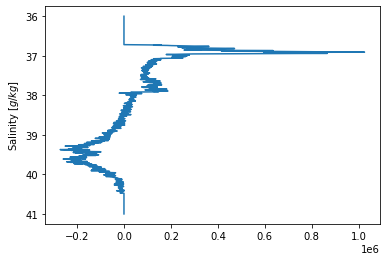

In [198]:
f, ax = plt.subplots(1)
plt.plot(out.q.mean("time").values, out.var_q.values)
ax.invert_yaxis()
ax.set_ylabel("Salinity $[g/kg]$")


